<a href="https://colab.research.google.com/github/sauravkumar19/Nifty_Price_Prediction-Using-Hybrid-Model-/blob/main/nifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
path = '/content/drive/MyDrive/ProjectA/^NSEI (3).csv'
data = pd.read_csv(path, parse_dates=["Date"],
                 index_col=["Date"])

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0.0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0.0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0.0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0.0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0


In [ ]:
min_date = data[data['Volume'] > 0]

In [ ]:
min_date.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-21,6085.750000,6094.350098,6065.100098,6082.299805,6082.299805,130900.0
2013-01-22,6080.149902,6101.299805,6040.500000,6048.500000,6048.500000,129000.0
2013-01-23,6052.850098,6069.799805,6021.149902,6054.299805,6054.299805,137000.0
2013-01-24,6046.200195,6065.299805,6007.850098,6019.350098,6019.350098,185200.0
2013-01-25,6024.500000,6080.549805,6014.450195,6074.649902,6074.649902,147600.0


In [ ]:
min_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2649 entries, 2013-01-21 to 2023-12-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2649 non-null   float64
 1   High       2649 non-null   float64
 2   Low        2649 non-null   float64
 3   Close      2649 non-null   float64
 4   Adj Close  2649 non-null   float64
 5   Volume     2649 non-null   float64
dtypes: float64(6)
memory usage: 144.9 KB


In [ ]:
nifty_price = pd.DataFrame(min_date['Close'])
nifty_price.head()

,Close
Date,
2013-01-21,6082.299805
2013-01-22,6048.500000
2013-01-23,6054.299805
2013-01-24,6019.350098
2013-01-25,6074.649902


Text(0, 0.5, 'Price')

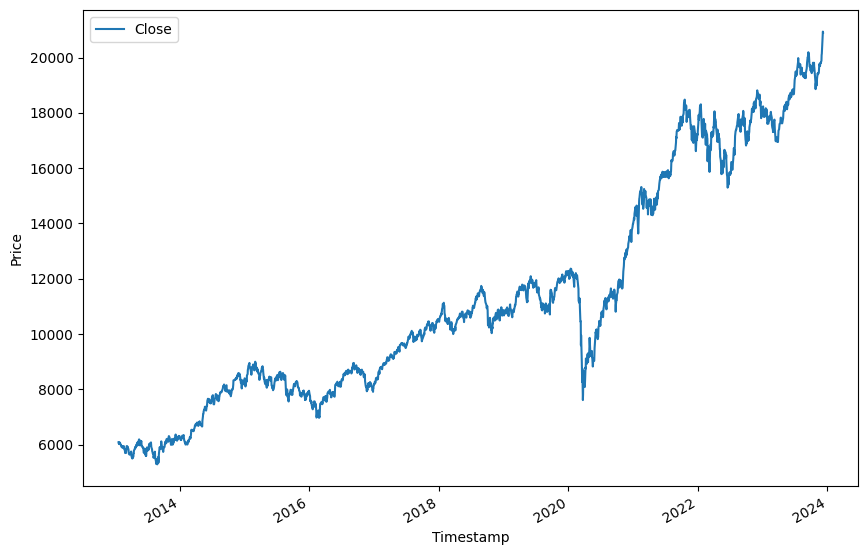

In [ ]:
import matplotlib.pyplot as plt
nifty_price.plot(figsize = (10,7))
plt.xlabel("Timestamp")
plt.ylabel("Price")

##Naive_base_model


In [ ]:
timestamp = nifty_price.index.to_numpy()
prices = nifty_price['Close'].to_numpy()

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timestamp[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timestamp[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2119, 530, 2119, 530)

In [ ]:
import tensorflow as tf
def mean_absolute_scale_error(y_pred,y_true):

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  naive_mae = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1]))

  return mae/naive_mae



In [ ]:
def evaluate_pred(y_true, y_pred):
  y_true = tf.cast(y_true,tf.float32)
  y_pred = tf.cast(y_pred,tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scale_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_pred(y_true=y_test[1:],
                               y_pred=y_test[:-1])
naive_results

{'mae': 120.541824,
 'mse': 24922.338,
 'rmse': 157.8681,
 'mape': 0.6838573,
 'mase': 0.9986821}

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2642, 2642)

In [ ]:
prices

array([ 6082.299805,  6048.5     ,  6054.299805, ..., 20855.099609,
       20937.699219, 20901.150391])

In [ ]:
full_windows[:10], full_labels[:10]

(array([[6082.299805, 6048.5     , 6054.299805, 6019.350098, 6074.649902,
         6074.799805, 6049.899902],
        [6048.5     , 6054.299805, 6019.350098, 6074.649902, 6074.799805,
         6049.899902, 6055.75    ],
        [6054.299805, 6019.350098, 6074.649902, 6074.799805, 6049.899902,
         6055.75    , 6034.75    ],
        [6019.350098, 6074.649902, 6074.799805, 6049.899902, 6055.75    ,
         6034.75    , 5998.899902],
        [6074.649902, 6074.799805, 6049.899902, 6055.75    , 6034.75    ,
         5998.899902, 5987.25    ],
        [6074.799805, 6049.899902, 6055.75    , 6034.75    , 5998.899902,
         5987.25    , 5956.899902],
        [6049.899902, 6055.75    , 6034.75    , 5998.899902, 5987.25    ,
         5956.899902, 5959.200195],
        [6055.75    , 6034.75    , 5998.899902, 5987.25    , 5956.899902,
         5959.200195, 5938.799805],
        [6034.75    , 5998.899902, 5987.25    , 5956.899902, 5959.200195,
         5938.799805, 5903.5     ],
        [5

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2113, 529, 2113, 529)

In [ ]:
import os
import tensorflow as tf

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

##Dense_model##

In [ ]:

from tensorflow.keras import layers
HORIZON = 1
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
17/17 [==============================] - 1s 36ms/step - loss: 5604.4771 - mae: 5604.4771 - val_loss: 215.5700 - val_mae: 215.5700
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 882.7964 - mae: 882.7964 - val_loss: 1188.9211 - val_mae: 1188.9211
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 362.5842 - mae: 362.5842 - val_loss: 437.6666 - val_mae: 437.6666
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 155.6762 - mae: 155.6762 - val_loss: 259.9458 - val_mae: 259.9458
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 117.6405 - mae: 117.6405 - val_loss: 233.8637 - val_mae: 233.8637
Epoch 6/100
17/17 [==============================] - 0s 19ms/step - loss: 122.4731 - mae: 122.4731 - val_loss: 208.3630 - val_mae: 208.3630
Epoch 7/100
17/17 [==============================] - 0s 22ms/step - loss: 111.2870 - mae: 111.2870 - val_loss: 191.1450 - val_mae: 191.1450
Epoch 8/100
17/17 [=

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 1ms/step - loss: 145.9242 - mae: 145.9242


[145.92417907714844, 145.92417907714844]

In [ ]:
def y_pred(model,y_test):

  y_pred = model.predict(y_test)

  return tf.squeeze(y_pred)

In [ ]:
model_1_pred = y_pred(model_1, test_windows)
model_1_pred[:10]

17/17 [==============================] - 0s 992us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([18138.547, 18304.066, 18449.512, 18500.182, 18428.924, 18340.127,
       18245.129, 18199.873, 18259.51 , 18272.379], dtype=float32)>

In [ ]:
# Evaluate preds
model_1_results = evaluate_pred(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_pred)
model_1_results

{'mae': 145.92415,
 'mse': 36614.38,
 'rmse': 191.34885,
 'mape': 0.82929254,
 'mase': 1.8079036}

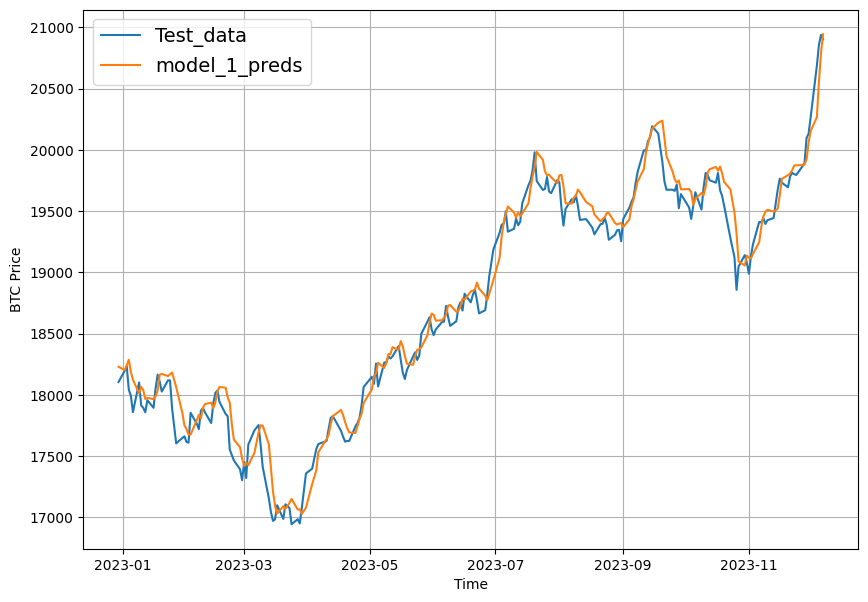

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset,format="-", label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_pred, start=offset, format="-", label="model_1_preds")

* Let's change the window size to 30
* Horizon be 1
* And fit the train model

In [ ]:
# Create 30 Days windows
full_windows_30, full_labels_30 = make_windows(prices, window_size = 30)
len(full_windows_30), len(full_labels_30)

(2619, 2619)

In [ ]:
train_windows_30, test_windows_30, train_labels_30, test_labels_30 = make_train_test_splits(full_windows_30, full_labels_30)
len(train_windows_30), len(test_windows_30), len(train_labels_30), len(test_labels_30)

(2095, 524, 2095, 524)

In [ ]:
tf.random.set_seed(42)

# Construct model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_2_dense") # give the model a name so we can save it

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_2.fit(x=train_windows_30, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels_30, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows_30, test_labels_30),
            callbacks=[create_model_checkpoint(model_name=model_2.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
17/17 [==============================] - 1s 28ms/step - loss: 2669.4822 - mae: 2669.4822 - val_loss: 1486.1112 - val_mae: 1486.1112
Epoch 2/100
17/17 [==============================] - 0s 19ms/step - loss: 431.3642 - mae: 431.3642 - val_loss: 564.6925 - val_mae: 564.6925
Epoch 3/100
17/17 [==============================] - 0s 20ms/step - loss: 233.6311 - mae: 233.6311 - val_loss: 339.7863 - val_mae: 339.7863
Epoch 4/100
17/17 [==============================] - 0s 19ms/step - loss: 188.6859 - mae: 188.6859 - val_loss: 309.2322 - val_mae: 309.2322
Epoch 5/100
17/17 [==============================] - 0s 19ms/step - loss: 175.3554 - mae: 175.3554 - val_loss: 308.0150 - val_mae: 308.0150
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 174.9265 - mae: 174.9265 - val_loss: 323.5312 - val_mae: 323.5312
Epoch 7/100
17/17 [==============================] - 0s 18ms/step - loss: 177.9888 - mae: 177.9888 - val_loss: 296.8269 - val_mae: 296.8269
Epoch 8/100
17/17

In [ ]:
# Evaluate model 2 preds
model_2.evaluate(test_windows_30, test_labels_30)

17/17 [==============================] - 0s 1ms/step - loss: 319.2793 - mae: 319.2793


[319.279296875, 319.279296875]

In [ ]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows_30, test_labels_30)

17/17 [==============================] - 0s 1ms/step - loss: 186.4609 - mae: 186.4609


[186.4608612060547, 186.4608612060547]

In [ ]:
# Get forecast predictions
model_2_preds = y_pred(model_2,test_windows_30)

17/17 [==============================] - 0s 1ms/step


In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_pred(y_true=tf.squeeze(test_labels_30), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 186.4608,
 'mse': 58862.777,
 'rmse': 242.61652,
 'mape': 1.0594331,
 'mase': 2.3084211}

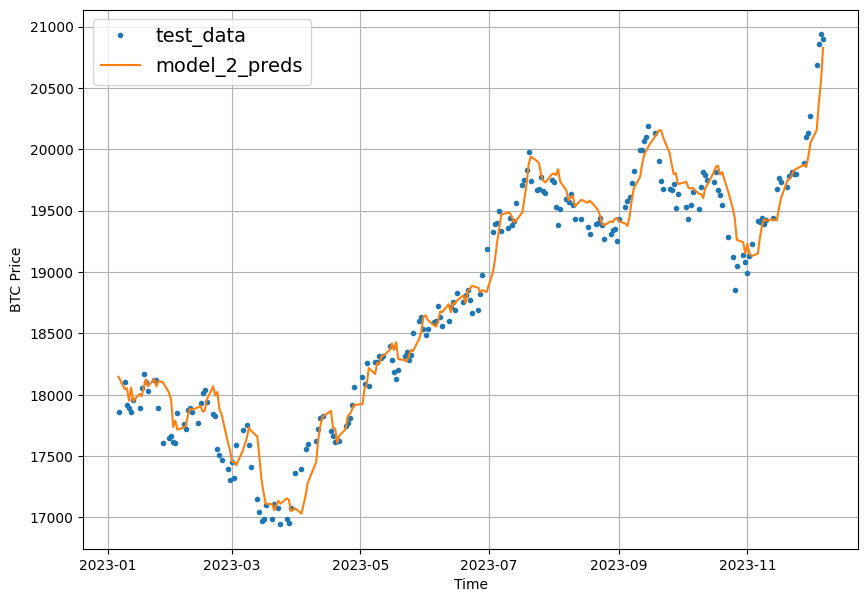

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows_30):], values=test_labels_30[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows_30):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## LSTM


In [ ]:
tf.random.set_seed(19)

#lets build the LSTM model

input = layers.Input(shape = 7)

x = layers.Lambda(lambda x: tf.expand_dims(x,axis = 1))(input)
x = layers.LSTM(128, activation = 'relu', return_sequences=True)(x)
x = layers.LSTM(128, activation = 'relu')(x)
x = layers.Dense(64, activation = 'linear')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=input, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
17/17 [==============================] - 4s 160ms/step - loss: 8732.0537 - val_loss: 13048.5557
Epoch 2/100
17/17 [==============================] - 2s 144ms/step - loss: 3678.1492 - val_loss: 3156.6360
Epoch 3/100
17/17 [==============================] - 4s 280ms/step - loss: 689.2722 - val_loss: 778.2327
Epoch 4/100
17/17 [==============================] - 3s 168ms/step - loss: 222.8603 - val_loss: 260.6019
Epoch 5/100
17/17 [==============================] - 2s 140ms/step - loss: 148.8196 - val_loss: 244.9210
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 143.0801 - val_loss: 246.4346
Epoch 7/100
17/17 [==============================] - 2s 138ms/step - loss: 140.0952 - val_loss: 244.0244
Epoch 8/100
17/17 [==============================] - 0s 8ms/step - loss: 139.3775 - val_loss: 247.5777
Epoch 9/100
17/17 [==============================] - 2s 144ms/step - loss: 138.5950 - val_loss: 242.3718
Epoch 10/100
17/17 [==============================] - 

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 172.5816


172.58163452148438

In [ ]:
# Make predictions with our LSTM model
model_5_preds = y_pred(model_5, test_windows)
model_5_preds[:10]

17/17 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([17997.49 , 18142.508, 18275.502, 18344.775, 18349.049, 18326.549,
       18284.592, 18249.531, 18243.814, 18229.072], dtype=float32)>

In [ ]:
# Evaluate model 5 preds
model_5_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 172.58159,
 'mse': 49643.824,
 'rmse': 222.80894,
 'mape': 0.97918904,
 'mase': 2.8013384}

In [ ]:
nifty_price.head()

,Close
Date,
2013-01-21,6082.299805
2013-01-22,6048.500000
2013-01-23,6054.299805
2013-01-24,6019.350098
2013-01-25,6074.649902


In [ ]:
df = min_date[['Close']]


In [ ]:
df.head(10)

,Close
Date,
2013-01-21,6082.299805
2013-01-22,6048.500000
2013-01-23,6054.299805
2013-01-24,6019.350098
2013-01-25,6074.649902
2013-01-28,6074.799805
2013-01-29,6049.899902
2013-01-30,6055.750000
2013-01-31,6034.750000


In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

Nifty_prices_windowed = df.copy()

NameError: ignored

In [ ]:


# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  Nifty_prices_windowed[f"Close+{i+1}"] = Nifty_prices_windowed["Close"].shift(periods=i+1)
#Nifty_prices_windowed[f"Volume+{1}"] = Nifty_prices_windowed["Volume"].shift(periods=1)
Nifty_prices_windowed.head(10)

,Close,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,,
2013-01-21,6082.299805,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-22,6048.500000,6082.299805,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-23,6054.299805,6048.500000,6082.299805,NaN,NaN,NaN,NaN,NaN
2013-01-24,6019.350098,6054.299805,6048.500000,6082.299805,NaN,NaN,NaN,NaN
2013-01-25,6074.649902,6019.350098,6054.299805,6048.500000,6082.299805,NaN,NaN,NaN
2013-01-28,6074.799805,6074.649902,6019.350098,6054.299805,6048.500000,6082.299805,NaN,NaN
2013-01-29,6049.899902,6074.799805,6074.649902,6019.350098,6054.299805,6048.500000,6082.299805,NaN
2013-01-30,6055.750000,6049.899902,6074.799805,6074.649902,6019.350098,6054.299805,6048.500000,6082.299805
2013-01-31,6034.750000,6055.750000,6049.899902,6074.799805,6074.649902,6019.350098,6054.299805,6048.500000


In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = Nifty_prices_windowed.dropna().drop(["Close"], axis=1).astype(np.float32)
y = Nifty_prices_windowed.dropna()["Close"].astype(np.float32)
X.head()

,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,
2013-01-30,6049.899902,6074.799805,6074.649902,6019.350098,6054.299805,6048.500000,6082.299805
2013-01-31,6055.750000,6049.899902,6074.799805,6074.649902,6019.350098,6054.299805,6048.500000
2013-02-01,6034.750000,6055.750000,6049.899902,6074.799805,6074.649902,6019.350098,6054.299805
2013-02-04,5998.899902,6034.750000,6055.750000,6049.899902,6074.799805,6074.649902,6019.350098
2013-02-05,5987.250000,5998.899902,6034.750000,6055.750000,6049.899902,6074.799805,6074.649902


In [ ]:
X.shape

(2642, 7)

In [ ]:
y.tail()

Date
2023-12-01    20267.900391
2023-12-04    20686.800781
2023-12-05    20855.099609
2023-12-06    20937.699219
2023-12-07    20901.150391
Name: Close, dtype: float32

In [ ]:
y.shape

(2642,)

In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2113, 2113, 529, 529)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
17/17 [==============================] - 2s 51ms/step - loss: 19246.1016 - val_loss: 3380.4700
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 5293.2847 - val_loss: 4667.1987
Epoch 3/100
17/17 [==============================] - 1s 41ms/step - loss: 2315.1548 - val_loss: 771.6820
Epoch 4/100
17/17 [==============================] - 0s 23ms/step - loss: 754.1346 - val_loss: 352.2238
Epoch 5/100
17/17 [==============================] - 0s 20ms/step - loss: 325.4685 - val_loss: 306.9816
Epoch 6/100
17/17 [==============================] - 0s 21ms/step - loss: 209.6310 - val_loss: 243.9775
Epoch 7/100
17/17 [==============================] - 0s 19ms/step - loss: 190.3428 - val_loss: 200.8783
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 191.6431 - val_loss: 210.7809
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 248.8444 - val_loss: 215.1942
Epoch 10/100
17/17 [==============================] - 0s 3ms/

In [ ]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

17/17 [==============================] - 0s 2ms/step - loss: 170.2824


170.28237915039062

## MultiInput data

In [ ]:
vol = min_date.copy()

In [ ]:
vol.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-21,6085.750000,6094.350098,6065.100098,6082.299805,6082.299805,130900.0
2013-01-22,6080.149902,6101.299805,6040.500000,6048.500000,6048.500000,129000.0
2013-01-23,6052.850098,6069.799805,6021.149902,6054.299805,6054.299805,137000.0
2013-01-24,6046.200195,6065.299805,6007.850098,6019.350098,6019.350098,185200.0
2013-01-25,6024.500000,6080.549805,6014.450195,6074.649902,6074.649902,147600.0


In [ ]:
vol['Relative_Volume'] = ((vol['Volume']-vol['Volume'].shift(1)) / vol['Volume'])*100

# Calculate candle body
vol['Candle_Body'] =   vol['Close'] - vol['Open']

# Calculate candle wick
vol['Candle_Wick'] = (vol['High'] - vol['Low']) - abs(vol['Candle_Body'])

In [ ]:
vol.head()

,Open,High,Low,Close,Adj Close,Volume,Relative_Volume,Candle_Body,Candle_Wick
Date,,,,,,,,,
2013-01-21,6085.750000,6094.350098,6065.100098,6082.299805,6082.299805,130900.0,NaN,-3.450195,25.799805
2013-01-22,6080.149902,6101.299805,6040.500000,6048.500000,6048.500000,129000.0,-1.472868,-31.649902,29.149903
2013-01-23,6052.850098,6069.799805,6021.149902,6054.299805,6054.299805,137000.0,5.839416,1.449707,47.200196
2013-01-24,6046.200195,6065.299805,6007.850098,6019.350098,6019.350098,185200.0,26.025918,-26.850097,30.599610
2013-01-25,6024.500000,6080.549805,6014.450195,6074.649902,6074.649902,147600.0,-25.474255,50.149902,15.949708


In [ ]:
vol['target_price'] = vol['Close'].shift(-1)

In [ ]:
vol.head(10)

,Open,High,Low,Close,Adj Close,Volume,Relative_Volume,Candle_Body,Candle_Wick,target_price
Date,,,,,,,,,,
2013-01-21,6085.750000,6094.350098,6065.100098,6082.299805,6082.299805,130900.0,NaN,-3.450195,25.799805,6048.500000
2013-01-22,6080.149902,6101.299805,6040.500000,6048.500000,6048.500000,129000.0,-1.472868,-31.649902,29.149903,6054.299805
2013-01-23,6052.850098,6069.799805,6021.149902,6054.299805,6054.299805,137000.0,5.839416,1.449707,47.200196,6019.350098
2013-01-24,6046.200195,6065.299805,6007.850098,6019.350098,6019.350098,185200.0,26.025918,-26.850097,30.599610,6074.649902
2013-01-25,6024.500000,6080.549805,6014.450195,6074.649902,6074.649902,147600.0,-25.474255,50.149902,15.949708,6074.799805
2013-01-28,6082.100098,6088.399902,6061.399902,6074.799805,6074.799805,113100.0,-30.503979,-7.300293,19.699707,6049.899902
2013-01-29,6064.700195,6111.799805,6042.450195,6049.899902,6049.899902,157600.0,28.236041,-14.800293,54.549317,6055.750000
2013-01-30,6065.000000,6071.950195,6044.149902,6055.750000,6055.750000,124200.0,-26.892110,-9.250000,18.550293,6034.750000
2013-01-31,6045.649902,6058.049805,6025.149902,6034.750000,6034.750000,168500.0,26.290801,-10.899902,22.000001,5998.899902


In [ ]:
X_1 = vol.iloc[6:-1][['Relative_Volume','Candle_Body','Candle_Wick']].dropna().astype(np.float32)

In [ ]:
X_1

,Relative_Volume,Candle_Body,Candle_Wick
Date,,,
2013-01-29,28.236040,-14.800293,54.549316
2013-01-30,-26.892109,-9.250000,18.550293
2013-01-31,26.290802,-10.899902,22.000002
2013-02-01,-5.775267,-42.050293,27.699707
2013-02-04,-12.420607,-37.950195,19.299805
...,...,...,...
2023-11-30,51.459103,24.650391,118.199219
2023-12-01,-83.069977,73.800781,34.050781
2023-12-04,30.254526,84.851562,110.048828


In [ ]:
y_1 =  vol.iloc[6:]["target_price"].dropna().astype(np.float32)

In [ ]:
y_1

Date
2013-01-29     6055.750000
2013-01-30     6034.750000
2013-01-31     5998.899902
2013-02-01     5987.250000
2013-02-04     5956.899902
                  ...     
2023-11-30    20267.900391
2023-12-01    20686.800781
2023-12-04    20855.099609
2023-12-05    20937.699219
2023-12-06    20901.150391
Name: target_price, Length: 2642, dtype: float64

In [ ]:
split_size = int(len(X) * 0.8)
X_train_1 = X_1[:split_size]
X_test_1 = X_1[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2113, 2113, 529, 529)

In [ ]:
X_1.shape

(2642, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming 'num_features' is the number of features excluding the 'Close' price
# Assuming 'window_size' is set to 7 for the 7-day window

# Define input shapes
price_input_shape = (7, 1)  # Assuming 'Close' is the target variable
volume_input_shape = (3,)  # Adjust num_features based on your dataset

# Create the first LSTM layer for processing price data
price_input = tf.keras.Input(shape=price_input_shape, name='price_input')
lstm_layer = layers.LSTM(128, activation='relu',return_sequences=True)(price_input)
lstm_layer = layers.LSTM(128, activation='relu')(lstm_layer)

# Create the second input layer for volume and other features
volume_input = tf.keras.Input(shape=volume_input_shape, name='volume_input')

# Concatenate the output of the first LSTM layer with the volume input
concatenated = layers.concatenate([lstm_layer, volume_input])

# Create the second dense layer for further processing
dense_layer = layers.Dense(128, activation='relu')(concatenated)
dense_layer = layers.Dense(128, activation='relu')(dense_layer)

# Create the output layer
output = layers.Dense(1, activation='linear')(dense_layer)

# Create the model
model_7 = models.Model(inputs=[price_input, volume_input], outputs=output,name="model_7_dense_concatenated")

# Display the model summary
model_7.summary()


Model: "model_7_dense_concatenated"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 price_input (InputLayer)    [(None, 7, 1)]               0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 7, 128)               66560     ['price_input[0][0]']         
                                                                                                  
 lstm_3 (LSTM)               (None, 128)                  131584    ['lstm_2[0][0]']              
                                                                                                  
 volume_input (InputLayer)   [(None, 3)]                  0         []                            
                                                                         

In [ ]:
y_train.shape

(2113,)

In [ ]:
model_7.compile(optimizer='adam', loss="mae")

# Training the model
model_7.fit([X_train,X_train_1], y_train, epochs=100, batch_size=128, validation_data=([X_test,X_test_1], y_test),
            callbacks=[create_model_checkpoint(model_name=model_7.name)])

# Evaluating the model
loss = model_7.evaluate([X_test,X_test_1], y_test)
print("Test Loss:", loss)

Epoch 1/100
17/17 [==============================] - 9s 362ms/step - loss: 4242.8921 - val_loss: 965.3359
Epoch 2/100
17/17 [==============================] - 5s 332ms/step - loss: 368.7923 - val_loss: 687.1722
Epoch 3/100
17/17 [==============================] - 4s 258ms/step - loss: 369.2547 - val_loss: 207.8703
Epoch 4/100
17/17 [==============================] - 1s 51ms/step - loss: 147.6761 - val_loss: 261.6511
Epoch 5/100
17/17 [==============================] - 1s 51ms/step - loss: 131.8204 - val_loss: 3337.5586
Epoch 6/100
17/17 [==============================] - 1s 79ms/step - loss: 232.0713 - val_loss: 229.7949
Epoch 7/100
17/17 [==============================] - 6s 357ms/step - loss: 132.1076 - val_loss: 159.8774
Epoch 8/100
17/17 [==============================] - 1s 52ms/step - loss: 100.4112 - val_loss: 244.0611
Epoch 9/100
17/17 [==============================] - 5s 306ms/step - loss: 137.8305 - val_loss: 159.4951
Epoch 10/100
17/17 [==============================] - 1s 

In [ ]:
model_6 = tf.keras.models.load_model("/content/model_experiments/model_7_dense_concatenated")
model_6.evaluate([X_test,X_test_1], y_test)

17/17 [==============================] - 1s 15ms/step - loss: 150.6136


150.61355590820312

In [ ]:
vol.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-21,6085.750000,6094.350098,6065.100098,6082.299805,6082.299805,130900.0
2013-01-22,6080.149902,6101.299805,6040.500000,6048.500000,6048.500000,129000.0
2013-01-23,6052.850098,6069.799805,6021.149902,6054.299805,6054.299805,137000.0
2013-01-24,6046.200195,6065.299805,6007.850098,6019.350098,6019.350098,185200.0
2013-01-25,6024.500000,6080.549805,6014.450195,6074.649902,6074.649902,147600.0


In [ ]:
b = np.expand_dims(vol['High'].to_numpy(),axis = 0)
b


array([[ 6094.350098,  6101.299805,  6069.799805, ..., 20864.050781,
        20961.949219, 20941.25    ]])

In [ ]:
b = vol['High'].to_numpy()
b

array([ 6094.350098,  6101.299805,  6069.799805, ..., 20864.050781,
       20961.949219, 20941.25    ])

In [ ]:
a = np.expand_dims(np.arange(len(vol['High'])-3), axis =1).reshape((378,7))
a

array([[   0,    1,    2, ...,    4,    5,    6],
       [   7,    8,    9, ...,   11,   12,   13],
       [  14,   15,   16, ...,   18,   19,   20],
       ...,
       [2625, 2626, 2627, ..., 2629, 2630, 2631],
       [2632, 2633, 2634, ..., 2636, 2637, 2638],
       [2639, 2640, 2641, ..., 2643, 2644, 2645]])

In [ ]:
b[a]

array([[ 6094.350098,  6101.299805,  6069.799805, ...,  6080.549805,
         6088.399902,  6111.799805],
       [ 6071.950195,  6058.049805,  6052.950195, ...,  5970.350098,
         5990.899902,  5978.5     ],
       [ 5953.700195,  5924.149902,  5927.649902, ...,  5940.200195,
         5899.950195,  5911.      ],
       ...,
       [19175.25    , 19276.25    , 19423.      , ..., 19464.400391,
        19463.900391, 19451.300781],
       [19494.400391, 19693.199219, 19875.25    , ..., 19756.449219,
        19829.099609, 19825.550781],
       [19875.150391, 19832.849609, 19916.849609, ..., 20158.699219,
        20291.550781, 20702.650391]])